In [1]:
%load_ext autoreload
%autoreload 2
import pymc4 as pm
import tensorflow as tf
from tensorflow_probability import bijectors
import numpy as np
import matplotlib.pyplot as plt

# Linear Regression

In [11]:
# Logp calculation for linear regression 
@pm.model(auto_name=True)
def rugby():    
    # Define priors
    home = pm.Normal(mu=0, sigma=2)
    sd_att = pm.HalfNormal(sigma=2.5)
    sd_def = pm.HalfNormal(sigma=2.5)
    intercept = pm.Normal(mu=0, sigma=2)

    # team-specific model parameters
    atts_star = pm.Normal(mu=0, sigma=tf.fill([6],sd_att))
    defs_star = pm.Normal(mu=0, sigma=tf.fill([6],sd_def))

    atts = atts_star - tf.mean(atts_star)
    defs = defs_star - tf.mean(defs_star)
    home_theta = tf.exp(intercept + home + atts[home_team] + defs[away_team])
    away_theta = tf.exp(intercept + atts[away_team] + defs[home_team])

    # likelihood of observed data
    home_points = pm.Poisson(mu=home_theta, observed=observed_home_goals)
    away_points = pm.Poisson(mu=away_theta, observed=observed_away_goals)
    
model = rugby.configure()

forward_sample = model.forward_sample()

AttributeError: 'BinOp' object has no attribute 'func'

In [17]:
# Logp calculation for linear regression 
@pm.model(auto_name=True)
def linreg(n_points=10):
    # Define priors
    sigma = pm.HalfNormal(sigma=1.)
    intercept = pm.Normal(mu=0, sigma=.1)
    x_coeff = pm.Normal(mu=0, sigma=1.)
    x = np.linspace(-5, 5, n_points)
    # Define likelihood
    y = pm.Normal(mu=intercept + x_coeff * x, sigma=sigma)

model = linreg.configure()

forward_sample = model.forward_sample()

In [ ]:
        def log_prob(*args):
            context = contexts.InferenceContext(args, expected_vars=self._forward_context.vars)
            with context:
                self._evaluate()
                logp = sum(tf.reduce_sum(var.log_prob(),
                axis=tf.range(1, tf.rank(var.log_prob()))) for var in context.vars)
                return logp

        return log_prob

    def forward_sample(self, *args, **kwargs):
        """Simulate data from the model via forward sampling."""
        with self._forward_context as context:
            samples = {var.name: var.sample() for var in context.vars}
        return samples

    def observe(self, **kwargs):
        """Condition the model on observed data."""
        model = copy.copy(self)
        model._observations.update(kwargs)
        return model

    def sample_posterior(self, num_results=100, num_burnin_steps=10, num_leapfrog_steps=10, step_size=0.005, num_chains=10):
        """Samples from the posterior of model."""
        log_prob_func = tf.function(self.make_log_prob_function())
        # Create input tensors
        var_names = [var.name for var in self._forward_context.vars]
        forward_sample = tf.vectorized_map(self.forward_sample, 
                                           tf.range(num_chains))

        initial_state = [
            forward_sample[var_name] for var_name in var_names
        ]

        kernel = tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=log_prob_func,
            num_leapfrog_steps=num_leapfrog_steps,
            step_size=step_size)

        kernel = tfp.mcmc.SimpleStepSizeAdaptation(
            inner_kernel=kernel, 
            num_adaptation_steps=int(num_burnin_steps * 0.8))

        samples, stats = tfp.mcmc.sample_chain(
            num_results=num_results,
            num_burnin_steps=num_burnin_steps,
            current_state=initial_state,
            kernel=kernel,
            #trace_fn=None,
        )

        # Create arviz trace
        trace = {var_name: np.swapaxes(sample.numpy()[num_burnin_steps:], 0, 1) for var_name, sample in zip(var_names, samples)}
        trace = az.from_dict(trace)
        return trace, stats, forward_sample


In [21]:
trace, stats, fwd_sample = model.sample_posterior(2000, num_burnin_steps=1000, step_size=1e-5)

W0528 15:56:06.015751 4445222336 pfor.py:2409] Note that RandomStandardNormal inside pfor op may not give same output as inside a sequential loop.
W0528 15:56:06.144493 4445222336 pfor.py:2409] Note that RandomStandardNormal inside pfor op may not give same output as inside a sequential loop.
W0528 15:56:06.287142 4445222336 pfor.py:2409] Note that RandomStandardNormal inside pfor op may not give same output as inside a sequential loop.
W0528 15:56:06.602088 4445222336 pfor.py:2409] Note that RandomStandardNormal inside pfor op may not give same output as inside a sequential loop.
/Users/twiecki/anaconda3/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [25]:
stats.inner_results.is_accepted

<tf.Tensor: id=11559505, shape=(2000, 10), dtype=bool, numpy=
array([[ True,  True, False, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ..., False, False,  True]])>

In [22]:
trace.posterior

<xarray.Dataset>
Dimensions:    (chain: 10, draw: 1000, y_dim_0: 10)
Coordinates:
  * chain      (chain) int64 0 1 2 3 4 5 6 7 8 9
  * draw       (draw) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * y_dim_0    (y_dim_0) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    sigma      (chain, draw) float32 -0.2710359 -0.27101877 -0.27155918 ...
    intercept  (chain, draw) float32 0.05683983 0.057115283 0.05718955 ...
    x_coeff    (chain, draw) float32 0.40238467 0.40235785 0.40151116 ...
    y          (chain, draw, y_dim_0) float32 -1.1509484 -1.8270247 ...
Attributes:
    created_at:  2019-05-28T19:58:25.332465

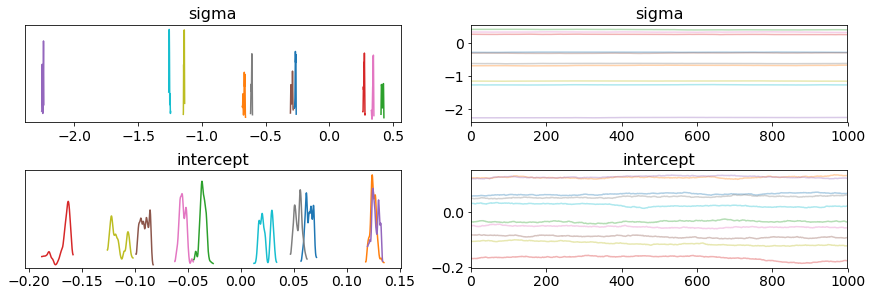

In [23]:
import arviz as az
az.plot_trace(trace, var_names=['sigma', 'intercept']);

In [145]:
import tensorflow_probability as tfp
import arviz as az

def sample(model, num_results=100, num_burnin_steps=10):
    """Samples from the pooled model."""
    log_prob_func = tf.function(model.make_log_prob_function())
    var_names = [var.name for var in model._forward_context.vars]
    forward_sample = model.forward_sample()
    initial_state = [
        forward_sample[var_name] for var_name in var_names
    ]
    
    hmc = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=log_prob_func,
      num_leapfrog_steps=10,
      step_size=0.005)

    # Contrain `sigma` to the positive real axis. Other variables are
    # unconstrained.
    identity_bijectors = [bijectors.Identity() for _ in initial_state]
    
    kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc, bijector=identity_bijectors)

    samples = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=kernel,
      trace_fn=None,
    )

    trace = {var_name: sample.numpy()[np.newaxis, ...] for var_name, sample in zip(var_names, samples)}
    trace = az.from_dict(trace)
    return trace

trace = sample(model, 500)

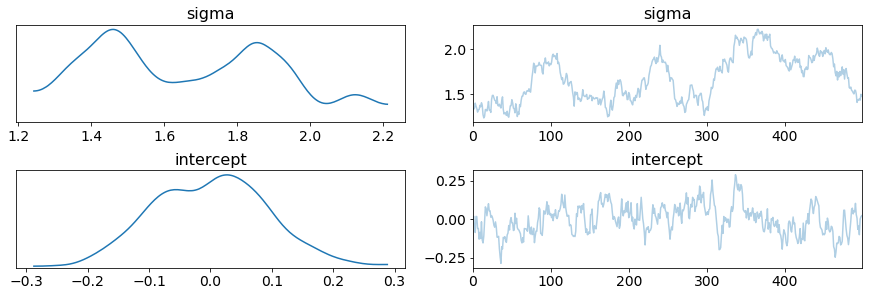

In [134]:
var_names = [var.name for var in model._forward_context.vars]

In [140]:
trace = {var_name: sample.numpy()[np.newaxis, ...] for var_name, sample in zip(var_names, samples)}

In [141]:
az.from_dict(trace)

Inference data with groups:
	> posterior

Missing stuff:
1. Observe support. Main question: API (easy)
2. Posterior MCMC sampling:
 1. Create input tensors (use forward sample tensors? also see 3), 
 2. create log_prob_func (done), 
 3. Pass it into TFP MCMC sampler
 4. Figure out how to do multiple chains
3. Shapes (difficult)
4. Posterior predictive (easy)

In [ ]:
model.observe(y=np.array([...])) 
              
posterior_sample(observed={y: np.array([...])})

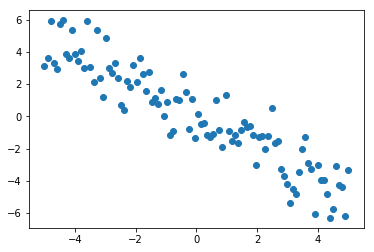

In [27]:
plt.scatter(np.linspace(-5, 5, 100), forward_sample['y'])

In [82]:
log_prob = model.make_log_prob_function()

In [84]:
log_prob(forward_sample['sigma'], 
     forward_sample['sigma'],
     forward_sample['x_coeff'],
     forward_sample['y'])

<tf.Tensor: id=6996, shape=(), dtype=float32, numpy=nan>

# Centered-Eight 

In [90]:
x = pm.Normal(mu=0, sigma=1)

In [97]:
x._untransformed_distribution.sample(5)

<tf.Tensor: id=7670, shape=(5,), dtype=float32, numpy=
array([-0.5129727 , -0.40249494,  0.1429924 ,  1.1307446 ,  0.07746322],
      dtype=float32)>

In [96]:
x.sample(5)

TypeError: sample() takes 1 positional argument but 2 were given

In [87]:
schools = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.], dtype='float32')
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.], dtype='float32')
n_points = 8

@pm.model(auto_name=True)
def centered_eight(n_points = n_points):    
    # Define priors
    mu = pm.Normal(mu=0, sigma=5)
    tau = pm.HalfCauchy(beta=.1, bijector=bijectors.Identity())
    theta = pm.Normal(mu=tf.fill([8], mu), 
                      sigma=tf.fill([8], tau))
    
    # Define likelihood
    y = pm.Normal(mu=theta, sigma=theta)
    
model = centered_eight.configure()

forward_sample = model.forward_sample()

forward_sample

{'mu': <tf.Tensor: id=7426, shape=(), dtype=float32, numpy=3.632758>,
 'tau': <tf.Tensor: id=7454, shape=(), dtype=float32, numpy=0.087374896>,
 'theta': <tf.Tensor: id=7476, shape=(8,), dtype=float32, numpy=
 array([-0.42838177, -0.41043675, -0.46137244, -0.40482295, -0.43679205,
        -0.42581567, -0.42336673, -0.41697466], dtype=float32)>,
 'y': <tf.Tensor: id=7498, shape=(8,), dtype=float32, numpy=
 array([-0.34451213, -0.37508628, -0.45916733,  0.13191423, -0.3355642 ,
        -0.13136804, -0.21465977, -0.99086416], dtype=float32)>}

In [23]:
logp_func = model.make_log_prob_function()
logp_func(forward_sample['mu'], forward_sample['tau'],
          forward_sample['theta'], schools)

<tf.Tensor: id=4496, shape=(), dtype=float32, numpy=-5692.7417>